# Instructions

* Download data from https://github.com/t-davidson/hate-speech-and-offensive-language
* Create a speech and offensive language detection model
  * Train and test various ml models
    * tfidf + logistic regression/svm  model
    * lstm, bert, xlnet models
* Compare models and select the best

# Content

* [Setup](#Setup)
* [Load data and clean data](#Load-data-and-clean-data)
* [Label distributions](#Label-distributions)
* [Eye-ball umap embeddings](#Eye-ball-umap-embeddings)
* [Classification problem](#Classification-problem)
 * [Classification with TF-IDF](#Classification-with-TF-IDF)
 * [Classification with Transformers](#Classification-with-Transformers)
* [Conclusions](#Conclusions)


## Setup

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:

import warnings
warnings.filterwarnings('ignore')

#!pip install transformers
#!pip install nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from IPython.display import display
import re
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/irina.vidal_migallon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load data and clean data



In [ ]:
file_name = "labeled_data.csv"

dataf = pd.read_csv(file_name)
dataf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [ ]:
dataf.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


Let's keep class and tweet for now:


In [ ]:
dataf = dataf.drop(columns=["Unnamed: 0", "count", "hate_speech", "offensive_language", "neither"])
dataf.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
def to_alphanumeric(text):
    text = text.lower()

    # Replacing RT signs with Empty String
    text = re.sub('(RT|rt)[\ ]@[^\s]+','',text)
    
    # Replacing Handlers with Empty String
    text = re.sub('@[^\s]+','',text)

    # Replacing URLs with Empty String
    text = re.sub(r"http\S+", "",text)

    # Remove all the special characters
    text = ' '.join(re.findall(r'\w+', text))

    # Replacing Single Characters with Empty String
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # Removing Extra Spaces
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    return text

# Remove stop words, special chars 
# stem the word tokens
def prepare_tokens(text):
    text = to_alphanumeric(text)

    stemmer = nltk.PorterStemmer()        
    tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z0-9]+')

    exceptions = list(string.punctuation)     
    exceptions += [
        "'re", "n't", "'m", "'s", "n't", "'s", 
        "``", "''", "'ve", "'m", "'ll", "'ve"]    
    stopw = set(stopwords.words("english") + exceptions)    

    tokens = tokenizer.tokenize(text)
    words = [stemmer.stem(t) for t in tokens if not t in stopw]
    return " ".join(words)  

# example using both...
print(to_alphanumeric(dataf["tweet"][0]))
print(prepare_tokens(dataf["tweet"][0]))


as woman you shouldn complain about cleaning up your house amp as man you should always take the trash out
woman complain clean hous amp man alway take trash


Somehow, it seems the exceptions may be confusing for a bert-like model - to be checked.

Now, preparing the dataset (either through simple clean-up or with proper tokenization).


In [ ]:
clean_df = dataf.copy()

# Option A: cleaning only
clean_df["tweet"] = dataf["tweet"].apply(lambda x: to_alphanumeric(x))
clean_df.head()

tokenized_df = clean_df.copy()

# Option B: including tokenization
# tokenized_df["tweet"] = clean_df["tweet"].apply(lambda x: prepare_tokens(x))
# tokenized_df.head()

## Label distributions

Look at distributions of "Hate speech" and "Offensive language"

<AxesSubplot:>

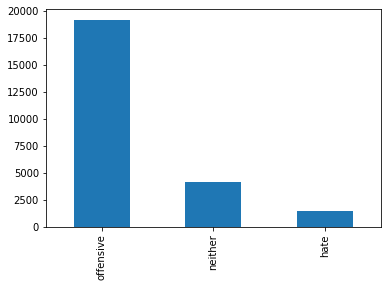

In [ ]:
labels = ["hate", "offensive", "neither"]
clean_df["class_name"] = clean_df["class"].apply(lambda x: labels[x])
clean_df["class_name"].value_counts().plot(kind='bar')

The problem seems imbalanced.

## Text length

<AxesSubplot:>

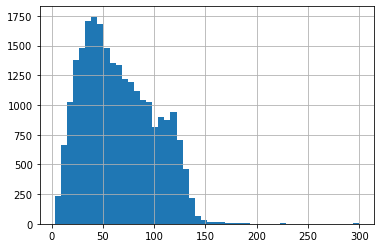

In [ ]:
clean_df["tweet"].map(len).clip(0, 300).hist(bins=50)

Let's get training/validation/test:

In [ ]:
from sklearn.model_selection import train_test_split

trainval_df, test_df = train_test_split(clean_df, test_size=0.3)
train_df, val_df = train_test_split(trainval_df, test_size=0.3)

## Eye-ball umap embeddings

In [ ]:
#!pip install umap-learn[plot]

In [ ]:
import umap
import umap.plot

In [ ]:
dataf = clean_df.copy()

In [ ]:
 # Embed the requirements in TFIDF-space
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X = vectorizer.fit_transform(dataf["tweet"])

# run umap.
mapper = umap.UMAP(metric='hellinger', random_state=2021).fit(X)

/home/irina.vidal_migallon/.venvs/nlpcamp/lib/python3.7/site-packages/umap/umap_.py:126: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 1216 edges.
It has only fully disconnected 48 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  f"A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.\n"


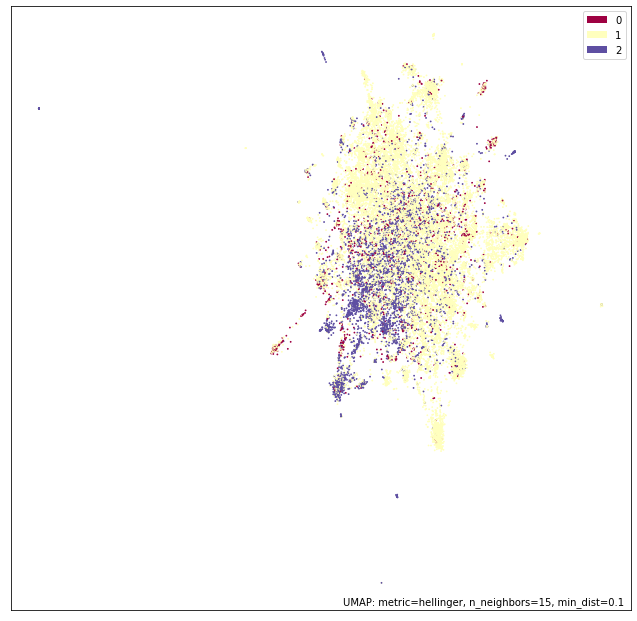

In [ ]:
# plot umap projection labeled by class

# keep some labels for plotting
labels = dataf["class"]

umap.plot.points(mapper, labels=labels);

In [ ]:
umap.plot.output_notebook()

Loading BokehJS ...

In [ ]:
hover_data = dataf[["tweet", "class"]].copy()

p = umap.plot.interactive(mapper, labels=labels, hover_data=hover_data, point_size=4)
umap.plot.show(p)

## Classification problem

---



In [ ]:
comparison = {} # store results here

### Classification with TF-IDF

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
def linear_classifier(data):
  pipeline = Pipeline([
      ("vec", TfidfVectorizer(ngram_range=(1,2))),
      ("model", SGDClassifier(loss="log", alpha=1e-5, penalty="l2", class_weight="balanced"))
  ])

  pipeline.fit(data["tweet"].values, data["class"].values)

  return pipeline

In [ ]:
lin_pipeline = linear_classifier(data=trainval_df)
predictions = lin_pipeline.predict(test_df["tweet"].values)

Evaluate it

In [ ]:
result_dict = classification_report(y_true=test_df["class"].values, y_pred=predictions, output_dict=True, digits=2)
result_df = pd.DataFrame(result_dict).drop(["weighted avg", "macro avg", "accuracy"], axis=1).T.sort_values(by="support", ascending=False)

Log metrics:

In [ ]:
print("Accuracy: {:.1%}".format(result_dict['accuracy']))

Accuracy: 89.7%


In [ ]:
result_dict['macro avg']

{'precision': 0.7542827617583909,
 'recall': 0.719793567901728,
 'f1-score': 0.7334239262693286,
 'support': 7435}

In [ ]:
result_dict
comparison["tfidf"] = {}
comparison["tfidf"]["eval_f1"] = result_dict['macro avg']['f1-score']

# Reminder: 0-hate, 1-offensive, 2-neither

{'tfidf': {'eval_f1': 0.7334239262693286}}

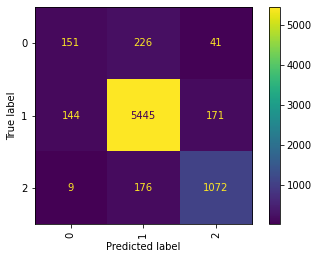

In [ ]:
labels = np.unique(test_df["class"].values)
cm = confusion_matrix(y_true=test_df["class"].values, y_pred=predictions, labels=labels)
cm_disp = ConfusionMatrixDisplay(cm, display_labels=labels)
cm_disp.plot(include_values=True, cmap='viridis', xticks_rotation='vertical', values_format=None);

### Classification with Transformers

In [ ]:
import torch
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score


In [ ]:
torch.__version__

'1.8.0'

In [ ]:
transformers.__version__


'4.4.2'

In [ ]:
from typing import Dict, List
from transformers.tokenization_utils_base import BatchEncoding


class ClassificationDataset(torch.utils.data.Dataset):
    """Dataset class to be used for functional requirements classifcation.

    :param encodings: Tokenized texts by transformers tokenizer.
    :param labels: Labels for each text in the encodings.
    :param target_names: List of possible label names.
    """

    def __init__(self, encodings: BatchEncoding, labels: List[str], target_names: List[str]):
        self.encodings = encodings
        self.labels = labels
        self.target_names = target_names

    def __getitem__(self, idx: int) -> Dict:
        """Return data and labels merged in one dict."""
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.target_names.index(self.labels[idx])])
        return item

    def __len__(self):
        """Get the number of samples."""
        return len(self.labels)


def get_classification_dataset_from_dataframe(
    dataf: pd.DataFrame,
    tokenizer: AutoTokenizer,
    target_names: List[str],
    max_length: int = 512,
    text_column: str = "tweet",
    label_column: str = "class",
) -> ClassificationDataset:
    if text_column not in dataf.columns:
        raise ValueError("'text_column' not found in dataframe.")
    if label_column not in dataf.columns:
        raise ValueError("'label_column' not found in dataframe.")
    encodings = tokenizer(dataf[text_column].values.tolist(), truncation=True, padding=True, max_length=max_length)
    labels = dataf[label_column].values.tolist()

    return ClassificationDataset(encodings=encodings, labels=labels, target_names=target_names)


def compute_metrics(pred) -> Dict:
    """Compute metrics while training when passed to a huggingface Trainer.

    :param pred: Prediction object with label_ids and predictions.
    :return: Dictionary containing metrics by key.
    """
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro"),
        "precision": precision_score(labels, preds, average="macro"),
    }

Let's get a training-evaluation loop, so we can iterate over several models:

In [ ]:
text_col = "tweet"
label_col = "class"

trainers = {}

def try_model(model_name, train_data, val_data, test_data, epochs=3):
    
    # derive label names
    target_names = train_df[label_col].unique().tolist()


    # load the pretrained tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)

    # prepare the huggingface datasets
    train_dataset = get_classification_dataset_from_dataframe(train_data, tokenizer, target_names, max_length=200, text_column=text_col, label_column=label_col)
    valid_dataset = get_classification_dataset_from_dataframe(val_data, tokenizer, target_names, max_length=200, text_column=text_col, label_column=label_col)

    # get a new model
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(train_dataset.target_names)).to("cuda")

    # setup training
    training_args = TrainingArguments(
      output_dir='./results',          
      num_train_epochs=epochs,           
      per_device_train_batch_size=32, 
      per_device_eval_batch_size=32,   
      warmup_steps=int(len(train_dataset)*0.1),  
      weight_decay=0.01,              
      learning_rate=5e-5,             
      lr_scheduler_type='linear',
      logging_dir='./logs',           
      load_best_model_at_end=True,    
      logging_steps=100,              
      evaluation_strategy="epoch",
      seed=2021,
      disable_tqdm=True,
    )

    trainer = Trainer(
      model=model,                         
      args=training_args,                  
      train_dataset=train_dataset,         
      eval_dataset=valid_dataset,          
      compute_metrics=compute_metrics,    
    )

    # train the model
    training_output = trainer.train()
    
    # save the model and tokenizer (can be loaded with .from_pretrained)
    save_directory = "results/{}_{}".format(model_name, epochs)

    tokenizer.save_pretrained(save_directory)
    model.save_pretrained(save_directory)

    test_dataset = get_classification_dataset_from_dataframe(test_df, tokenizer, target_names, max_length=200, text_column=text_col, label_column=label_col)
    
    eval_result = trainer.evaluate(eval_dataset=test_dataset)
    results = trainer.predict(test_dataset=test_dataset)
    predictions = results.predictions.argmax(axis=1)

    labels = np.unique(test_df["class"].values)
    cm = confusion_matrix(y_true=test_df["class"].values, y_pred=predictions, labels=labels)
    cm_disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    cm_disp.plot(include_values=True, cmap='viridis', xticks_rotation='vertical', values_format=None);
    
    return eval_result, trainer


Let's start with small models, so training is fast. Since it's twitter, perhaps very few epochs could yield half-decent results?

In [ ]:
model_names = ["albert-base-v2", "distilbert-base-uncased"]

In [ ]:
for name in model_names:
    epochs = 4
    eval_result, trainer = try_model(name, train_data=train_df, val_data=val_df, test_data=test_df, epochs=epochs)
    name += "_{}".format(epochs)
    comparison[name] = eval_result
    trainers[name] = trainer
    print("Quality for {}\Accuracy:\t{:.1%}\nF1-Score:\t{:.1%}\nPrecision:\t{:.1%}\nRecall:\t\t{:.1%}".format(name, eval_result["eval_accuracy"], 
                                                                                           eval_result["eval_f1"], 
                                                                                           eval_result["eval_precision"], 
                                                                                           eval_result["eval_recall"]))


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

{'loss': 0.5832, 'learning_rate': 4.118616144975288e-05, 'epoch': 0.79}
{'eval_loss': 0.30877751111984253, 'eval_accuracy': 0.8979827089337176, 'eval_f1': 0.5981351665594276, 'eval_recall': 0.6409579373597304, 'eval_precision': 0.5642289884925354, 'eval_runtime': 16.8406, 'eval_samples_per_second': 309.074, 'epoch': 1.0}
{'train_runtime': 139.3137, 'train_samples_per_second': 0.912, 'epoch': 1.0}
{'eval_loss': 0.30963391065597534, 'eval_accuracy': 0.8995292535305985, 'eval_f1': 0.5971022257955575, 'eval_recall': 0.6374690621408998, 'eval_precision': 0.564927791856776, 'eval_runtime': 23.7639, 'eval_samples_per_second': 312.87, 'epoch': 1.0}
Quality for albert-base-v2\Accuracy:	90.0%
F1-Score:	59.7%
Precision:	56.5%
Recall:		63.7%


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

{'loss': 0.5825, 'learning_rate': 4.118616144975288e-05, 'epoch': 0.79}
{'eval_loss': 0.26726019382476807, 'eval_accuracy': 0.9095100864553314, 'eval_f1': 0.717352197953559, 'eval_recall': 0.6967445525147188, 'eval_precision': 0.7840810988838456, 'eval_runtime': 12.8928, 'eval_samples_per_second': 403.714, 'epoch': 1.0}
{'train_runtime': 99.85, 'train_samples_per_second': 1.272, 'epoch': 1.0}
{'eval_loss': 0.2792717516422272, 'eval_accuracy': 0.9063887020847343, 'eval_f1': 0.7053818605326864, 'eval_recall': 0.6846208111238415, 'eval_precision': 0.7604393631869854, 'eval_runtime': 14.5184, 'eval_samples_per_second': 512.11, 'epoch': 1.0}
Quality for distilbert-base-uncased\Accuracy:	90.6%
F1-Score:	70.5%
Precision:	76.0%
Recall:		68.5%


And the whole data is:

In [ ]:
for name in model_names:
    eval_result, trainer = try_model(name, train_data=train_df, val_data=val_df, test_data=test_df, epochs=1)
    comparison[name] = eval_result
    trainers[name] = trainer
    print("\n\nQuality for {}\nAccuracy:\t{:.1%}\nF1-Score:\t{:.1%}\nPrecision:\t{:.1%}\nRecall:\t\t{:.1%}".format(name, eval_result["eval_accuracy"], 
                                                                                           eval_result["eval_f1"], 
                                                                                           eval_result["eval_precision"], 
                                                                                           eval_result["eval_recall"]))
    

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

{'loss': 0.5832, 'learning_rate': 4.118616144975288e-05, 'epoch': 0.79}
{'eval_loss': 0.30877751111984253, 'eval_accuracy': 0.8979827089337176, 'eval_f1': 0.5981351665594276, 'eval_recall': 0.6409579373597304, 'eval_precision': 0.5642289884925354, 'eval_runtime': 16.791, 'eval_samples_per_second': 309.987, 'epoch': 1.0}
{'train_runtime': 134.8977, 'train_samples_per_second': 0.941, 'epoch': 1.0}
{'eval_loss': 0.30963391065597534, 'eval_accuracy': 0.8995292535305985, 'eval_f1': 0.5971022257955575, 'eval_recall': 0.6374690621408998, 'eval_precision': 0.564927791856776, 'eval_runtime': 23.7498, 'eval_samples_per_second': 313.055, 'epoch': 1.0}
Quality for albert-base-v2
Accuracy:	90.0%
F1-Score:	59.7%
Precision:	56.5%
Recall:		63.7%


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

{'loss': 0.5825, 'learning_rate': 4.118616144975288e-05, 'epoch': 0.79}
{'eval_loss': 0.26726019382476807, 'eval_accuracy': 0.9095100864553314, 'eval_f1': 0.717352197953559, 'eval_recall': 0.6967445525147188, 'eval_precision': 0.7840810988838456, 'eval_runtime': 12.8694, 'eval_samples_per_second': 404.449, 'epoch': 1.0}
{'train_runtime': 98.209, 'train_samples_per_second': 1.293, 'epoch': 1.0}
{'eval_loss': 0.2792717516422272, 'eval_accuracy': 0.9063887020847343, 'eval_f1': 0.7053818605326864, 'eval_recall': 0.6846208111238415, 'eval_precision': 0.7604393631869854, 'eval_runtime': 14.5032, 'eval_samples_per_second': 512.646, 'epoch': 1.0}
Quality for distilbert-base-uncased
Accuracy:	90.6%
F1-Score:	70.5%
Precision:	76.0%
Recall:		68.5%


It seems these models clearly need much more fine-tuning than this.

So let's try a bit longer:


In [ ]:
for name in model_names:
    eval_result, trainer = try_model(name, train_data=train_df, val_data=val_df, test_data=test_df, epochs=2)
    comparison[name] = eval_result
    trainers[name] = trainer
    print("Quality for {}\nAccuracy:\t{:.1%}\nF1-Score:\t{:.1%}\nPrecision:\t{:.1%}\nRecall:\t\t{:.1%}".format(name, eval_result["eval_accuracy"], 
                                                                                           eval_result["eval_f1"], 
                                                                                           eval_result["eval_precision"], 
                                                                                           eval_result["eval_recall"]))
    

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

{'loss': 0.4952, 'learning_rate': 4.118616144975288e-05, 'epoch': 0.79}
{'eval_loss': 0.30915746092796326, 'eval_accuracy': 0.8972142170989433, 'eval_f1': 0.5951472683051997, 'eval_recall': 0.611249454490329, 'eval_precision': 0.5799497213910301, 'eval_runtime': 16.8589, 'eval_samples_per_second': 308.738, 'epoch': 1.0}
{'loss': 0.3146, 'learning_rate': 8.237232289950576e-05, 'epoch': 1.57}
{'eval_loss': 0.3531615734100342, 'eval_accuracy': 0.8883765609990394, 'eval_f1': 0.6358144314558721, 'eval_recall': 0.6171315570861756, 'eval_precision': 0.7301409475214982, 'eval_runtime': 16.8622, 'eval_samples_per_second': 308.679, 'epoch': 2.0}
{'train_runtime': 271.9242, 'train_samples_per_second': 0.934, 'epoch': 2.0}
{'eval_loss': 0.313282310962677, 'eval_accuracy': 0.8964357767316745, 'eval_f1': 0.5915667360086427, 'eval_recall': 0.6066998419959339, 'eval_precision': 0.5772234833105953, 'eval_runtime': 23.7664, 'eval_samples_per_second': 312.836, 'epoch': 2.0}
Quality for albert-base-v2
Acc

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

{'loss': 0.5718, 'learning_rate': 4.118616144975288e-05, 'epoch': 0.79}
{'eval_loss': 0.2620700001716614, 'eval_accuracy': 0.9072046109510087, 'eval_f1': 0.6644972454650842, 'eval_recall': 0.6649802143431286, 'eval_precision': 0.7557170782402137, 'eval_runtime': 12.8882, 'eval_samples_per_second': 403.858, 'epoch': 1.0}
{'loss': 0.266, 'learning_rate': 8.237232289950576e-05, 'epoch': 1.57}
{'eval_loss': 0.24188373982906342, 'eval_accuracy': 0.9131604226705091, 'eval_f1': 0.7342933770126084, 'eval_recall': 0.7220140409691534, 'eval_precision': 0.7827100128765396, 'eval_runtime': 12.7775, 'eval_samples_per_second': 407.355, 'epoch': 2.0}
{'train_runtime': 195.3918, 'train_samples_per_second': 1.3, 'epoch': 2.0}
{'eval_loss': 0.25177693367004395, 'eval_accuracy': 0.9132481506388702, 'eval_f1': 0.7220730879294068, 'eval_recall': 0.7115528802924779, 'eval_precision': 0.7578845865316653, 'eval_runtime': 14.357, 'eval_samples_per_second': 517.867, 'epoch': 2.0}
Quality for distilbert-base-unc

Not great, definitely need longer. Albert even regressed a little. Let's try a bit longer.

In [ ]:
for name in model_names:
    eval_result, trainer = try_model(name, train_data=train_df, val_data=val_df, test_data=test_df, epochs=4)
    comparison[name] = eval_result
    trainers[name] = trainer
    print("\n\nQuality for {}\nAccuracy:\t{:.1%}\nF1-Score:\t{:.1%}\nPrecision:\t{:.1%}\nRecall:\t\t{:.1%}".format(name, eval_result["eval_accuracy"], 
                                                                                           eval_result["eval_f1"], 
                                                                                           eval_result["eval_precision"], 
                                                                                           eval_result["eval_recall"]))

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

{'loss': 0.5564, 'learning_rate': 4.118616144975288e-05, 'epoch': 0.79}
{'eval_loss': 0.2952745854854584, 'eval_accuracy': 0.9027857829010567, 'eval_f1': 0.6037759959511936, 'eval_recall': 0.6421321341309606, 'eval_precision': 0.572050691700316, 'eval_runtime': 16.7876, 'eval_samples_per_second': 310.051, 'epoch': 1.0}
{'loss': 0.305, 'learning_rate': 8.237232289950576e-05, 'epoch': 1.57}
{'eval_loss': 0.26435038447380066, 'eval_accuracy': 0.9039385206532181, 'eval_f1': 0.6692305627912054, 'eval_recall': 0.6703970768388664, 'eval_precision': 0.7427784250487246, 'eval_runtime': 16.8229, 'eval_samples_per_second': 309.401, 'epoch': 2.0}
{'loss': 0.2989, 'learning_rate': 0.00012355848434925866, 'epoch': 2.36}
{'eval_loss': 0.2851674258708954, 'eval_accuracy': 0.9033621517771374, 'eval_f1': 0.6118696333111723, 'eval_recall': 0.6264216995586275, 'eval_precision': 0.672560718583067, 'eval_runtime': 16.7676, 'eval_samples_per_second': 310.42, 'epoch': 3.0}
{'loss': 0.3063, 'learning_rate': 0.

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

{'loss': 0.5752, 'learning_rate': 4.118616144975288e-05, 'epoch': 0.79}
{'eval_loss': 0.2561415731906891, 'eval_accuracy': 0.90835734870317, 'eval_f1': 0.674206667016393, 'eval_recall': 0.6656339331178621, 'eval_precision': 0.7827891847048937, 'eval_runtime': 12.9126, 'eval_samples_per_second': 403.095, 'epoch': 1.0}
{'loss': 0.2626, 'learning_rate': 8.237232289950576e-05, 'epoch': 1.57}
{'eval_loss': 0.2372787445783615, 'eval_accuracy': 0.9125840537944284, 'eval_f1': 0.7428663042010412, 'eval_recall': 0.7237240146220995, 'eval_precision': 0.7917592110096309, 'eval_runtime': 12.8912, 'eval_samples_per_second': 403.763, 'epoch': 2.0}
{'loss': 0.2437, 'learning_rate': 0.00012355848434925866, 'epoch': 2.36}
{'eval_loss': 0.25468337535858154, 'eval_accuracy': 0.9087415946205571, 'eval_f1': 0.781089825116263, 'eval_recall': 0.7874961369816035, 'eval_precision': 0.776791182179839, 'eval_runtime': 12.8829, 'eval_samples_per_second': 404.024, 'epoch': 3.0}
{'loss': 0.2127, 'learning_rate': 0.0

DistillBERT is the one that seems to be responding, so let's focus on that one:

In [ ]:
name = "distilbert-base-uncased"
epochs = 6
eval_result, trainer = try_model(name, train_data=train_df, val_data=val_df, test_data=test_df, epochs=epochs)
name += "_" + str(epochs)
comparison[name] = eval_result
trainers[name] = trainer
print("\n\nQuality for {}\nAccuracy:\t{:.1%}\nF1-Score:\t{:.1%}\nPrecision:\t{:.1%}\nRecall:\t\t{:.1%}".format(name, eval_result["eval_accuracy"], 
                                                                                           eval_result["eval_f1"], 
                                                                                           eval_result["eval_precision"], 
                                                                                           eval_result["eval_recall"]))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

{'loss': 0.6011, 'learning_rate': 4.118616144975288e-05, 'epoch': 0.79}
{'eval_loss': 0.25345873832702637, 'eval_accuracy': 0.9121998078770414, 'eval_f1': 0.7498398215179637, 'eval_recall': 0.7405050528423462, 'eval_precision': 0.780579599064343, 'eval_runtime': 12.9337, 'eval_samples_per_second': 402.438, 'epoch': 1.0}
{'loss': 0.2586, 'learning_rate': 8.237232289950576e-05, 'epoch': 1.57}
{'eval_loss': 0.23056715726852417, 'eval_accuracy': 0.9164265129682997, 'eval_f1': 0.7575025429770784, 'eval_recall': 0.7427814298655416, 'eval_precision': 0.7939062417817762, 'eval_runtime': 12.9451, 'eval_samples_per_second': 402.083, 'epoch': 2.0}
{'loss': 0.2395, 'learning_rate': 0.00012355848434925866, 'epoch': 2.36}
{'eval_loss': 0.2620799243450165, 'eval_accuracy': 0.909702209414025, 'eval_f1': 0.784637149114921, 'eval_recall': 0.7885780646280214, 'eval_precision': 0.7808139965356746, 'eval_runtime': 12.9167, 'eval_samples_per_second': 402.966, 'epoch': 3.0}
{'loss': 0.2134, 'learning_rate': 

## Conclusions

* For such an imbalanced dataset, don't trust accuracy, and also consider whether it makes sense to balance it or it's better to live with it.
* If you have very little compute power, TF-IDF will perform better than BERT-like models trained for few epochs.
* As soon as you can train for 6+ epochs in a reasonable time on your system, it starts being reasonable to switch to Transformers-like models.